# Welcome to the SHAP Have-a-go episode!

Today we will be exploring two simplified use cases for using SHAP: for interpreting the results of an XGBoost model, and to help interpret clustering results. For this usecase we will be using the Boston housing price dataset. You can find a data dictionary and more information [here](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset/notebook).

You can also find the slides for this session [here](https://docs.google.com/presentation/d/1hhddAj4pX9lXtVe9oncDQh0OwwUp6QEJ1CFx4W4_Z1I/edit?usp=sharing). 


In [ ]:
# installations 
!pip install lightgbm
!pip install shap==0.39.0
!pip install xgboost
#!pip install sklearn

In [4]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
import lightgbm as lgb
import xgboost
import pandas as pd
import shap

**Load data and fit a very simple XGBoost model**

## On the dataset

**The Boston Housing Dataset** is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:


- **CRIM** - per capita crime rate by town
- **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS** - proportion of non-retail business acres per town.
- **CHAS** - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- **NOX** - nitric oxides concentration (parts per 10 million)
- **RM** - average number of rooms per dwelling
- **AGE** - proportion of owner-occupied units built prior to 1940
- **DIS** - weighted distances to five Boston employment centres
- **RAD** - index of accessibility to radial highways
- **TAX** - full-value property-tax rate per $10,000
- **PTRATIO** - pupil-teacher ratio by town

- **B** - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- **LSTAT** - % lower status of the population
- **MEDV** - Median value of owner-occupied homes in $1000's (y)

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [ ]:
# for the sake of this short session we will not be doing a train-test split as we don't care about overfitting
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.Explainer(bst, X)
shap_values = explainer(X)

**Using SHAP**

*Visualising a single prediction*

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], X.iloc[0,:])

*Visualising a subset*

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0:10], X.iloc[0:10,:])


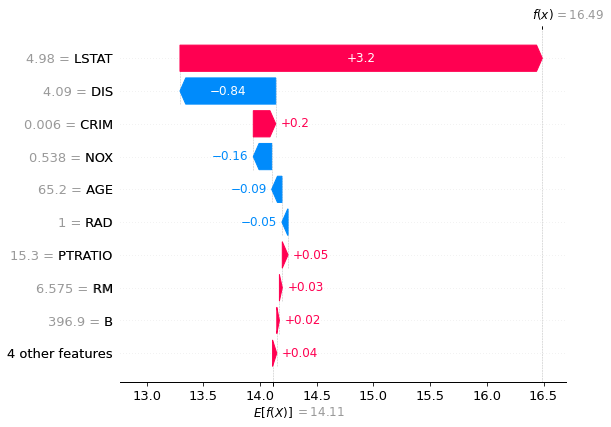

In [ ]:
# waterfall version
shap.initjs() 
shap.plots.waterfall(shap_values[0], max_display=10)

*Mean absolute SHAP value for each feature*

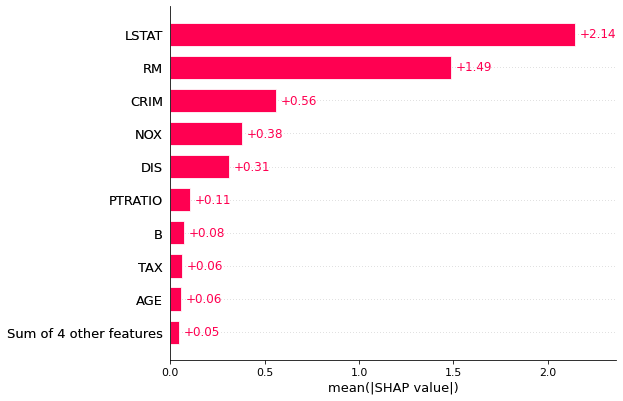

In [ ]:
shap.initjs()
shap.plots.bar(shap_values)

*Looking at the distributions and feature relevance*

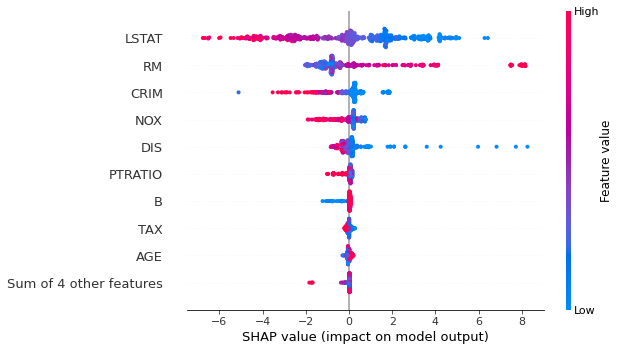

In [ ]:
shap.plots.beeswarm(shap_values)


# (Optional) Experimenting with clustering and SHAP. A short intro example. 

We will now use the same dataset to showcase how SHAP values can be used to help interpret the results of a clustering exercise. For simplicity we will once again use the whole sample to train a Kmeans model, and then fit a lgbm model with cluster labels as output. We will then calculate SHAP values. 

In [ ]:
# KMeans pre-processing
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = pd.DataFrame(min_max_scaler.fit_transform(X.copy().values), columns=X.columns)

In [ ]:
# K means - let's use k=3 for simplicity
km = KMeans(n_clusters=3, random_state=1301).fit(X_scaled)
preds = km.predict(X_scaled) # clusters
pd.Series(preds).value_counts()

1    190
2    180
0    136
dtype: int64

In [ ]:
# getting the lgbm classifier set up
params = lgb.LGBMClassifier().get_params()
params['objective'] = 'multiclass' # the target is the cluster #
params['is_unbalance'] = True
params['n_jobs'] = -1
params['random_state'] = 1301

mdl = lgb.LGBMClassifier(**params)

In [ ]:
# fit model. preds are the cluster labels from the Kmeans
mdl.fit(X, preds)
y_pred_km = mdl.predict_proba(X)

In [ ]:
# get SHAP explainer

explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X)

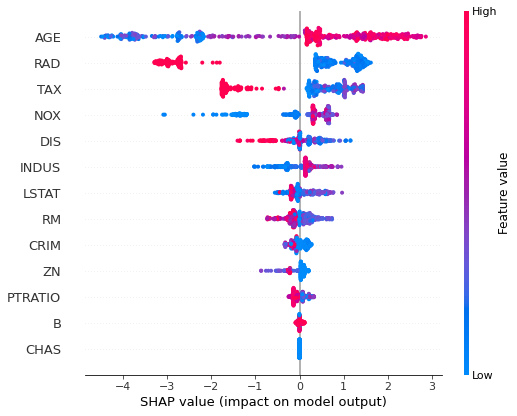

In [ ]:
# Beeswarm plot for cluster 1
shap.initjs()
shap.summary_plot(shap_values[1], X, max_display=20, show=False)
